In [1]:
from __future__ import print_function, division
import numpy as np
import h5py
import scipy.io
import random
import sys,os
import itertools
import numbers
from collections import Counter
from warnings import warn
from abc import ABCMeta, abstractmethod
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.metrics import roc_auc_score, average_precision_score
from sklearn.utils import shuffle
import matplotlib.pyplot as plt

In [2]:
import tensorflow as tf

In [3]:
# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(1337)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
#python_random.seed(1337)

# The below set_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see:
# https://www.tensorflow.org/api_docs/python/tf/random/set_seed
tf.random.set_seed(1337)
#older version of tensorflow
#tf.set_random_seed(1337)

In [4]:
gpus = tf.config.experimental.list_physical_devices(device_type='GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)
os.environ['CUDA_VISIBLE_DEVICES'] = "0"

In [5]:
num_threads = 8
# Maximum number of threads to use for OpenMP parallel regions.
os.environ["OMP_NUM_THREADS"] = "8"
# Without setting below 2 environment variables, it didn't work for me. Thanks to @cjw85 
os.environ["TF_NUM_INTRAOP_THREADS"] = "8"
os.environ["TF_NUM_INTEROP_THREADS"] = "8"

tf.config.threading.set_inter_op_parallelism_threads(
    num_threads
)
tf.config.threading.set_intra_op_parallelism_threads(
    num_threads
)
tf.config.set_soft_device_placement(True)

In [6]:
from tensorflow.keras.optimizers import *
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.constraints import MaxNorm
from tensorflow.keras.regularizers import (
    l2, 
    l1, 
    l1_l2
)
from tensorflow.keras.models import Model
from tensorflow.keras import backend as K
from tensorflow.keras import (
    activations, 
    initializers, 
    regularizers, 
    constraints
)

In [7]:
from tensorflow.keras.callbacks import (
    ModelCheckpoint, 
    EarlyStopping
)
from sklearn.metrics import (
    roc_curve,
    auc,
    roc_auc_score,
    average_precision_score,
    precision_recall_curve,
)

In [8]:
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils import resample, shuffle
from sklearn.feature_selection import (
    SelectKBest,
    chi2
)
from collections import defaultdict

In [9]:
from attention_layer import Attention, attention_flatten

In [10]:
def build_model():
	print('building model')

	seq_input_shape = (1000,4)
	nb_filter = 256
	filter_length = 9
	attentionhidden = 256

	seq_input = Input(shape = seq_input_shape, name = 'seq_input')
	convul1   = Convolution1D(filters = nb_filter,
                        	  kernel_size = filter_length,
                        	  padding = 'valid',
                        	  activation = 'relu',
                        	  kernel_constraint = MaxNorm(3),
                        	  )

	pool_ma1 = MaxPooling1D(pool_size = 3)
	dropout1 = Dropout(0.5977908689086315)
	dropout2 = Dropout(0.50131233477637737)
	decoder  = Attention(hidden = attentionhidden, activation = 'linear')
	dense1   = Dense(1)
	dense2   = Dense(1)

	output_1 = pool_ma1(convul1(seq_input))
	output_2 = dropout1(output_1)
	att_decoder  = decoder(output_2)
	output_3 = attention_flatten(output_2.shape[2])(att_decoder)

	output_4 =  dense1(dropout2(Flatten()(output_2)))
	all_outp =  concatenate([output_3, output_4])
	output_5 =  dense2(all_outp)
	output_f =  Activation('sigmoid')(output_5)

	model = Model(inputs = seq_input, outputs = output_f)
	model.compile(loss = 'binary_crossentropy', optimizer = 'nadam', metrics = ['accuracy'])

	#print(model.summary())
	return model


In [11]:
def data_processing():
    x_visdb = np.load('data/x_VISDB_fulldata.npy')
    y_visdb = np.load('data/y_VISDB_fulldata.npy')

    ###split 9:1
    trainx, valx, trainy, valy = train_test_split(x_visdb, y_visdb, test_size = 0.1, stratify=y_visdb #, random_state=42
                                                    )

    ##test 1:1
    neg_val = np.where(valy == 0)
    pos_val = np.where(valy == 1)
    xval_positive = valx[pos_val]
    yval_positive = valy[pos_val]
    xval_negative = valx[neg_val]
    yval_negative = valy[neg_val]

    permutation = np.random.permutation(xval_negative.shape[0])
    xval_negative_1 = xval_negative[permutation[:xval_positive.shape[0]], :, :]
    yval_negative_1 = yval_negative[permutation[:xval_positive.shape[0]]]

    xval_1 = np.concatenate((xval_positive, xval_negative_1), axis=0)
    yval_1 = np.concatenate((yval_positive, yval_negative_1), axis=0)
    xval_2, yval_2 = shuffle(xval_1, yval_1 #, random_state=42
                            )

    trainx2, trainy2 = shuffle(trainx, trainy #, random_state = 42
                            )
    
    return trainx2, trainy2, xval_2, yval_2


In [12]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap
import seaborn as sns

In [ ]:
#input layer
#reducerMNIST = umap.UMAP()
#embeddingMNIST = reducerMNIST.fit_transform(pred.reshape(-1, (pred.shape[1]*pred.shape[2])))
#sns.scatterplot(x = embeddingMNIST[:,0], y = embeddingMNIST[:,1], hue = valy, palette = ['pink', 'green'], legend = 'full')

In [ ]:
#conv-pooling flattened layer
#reducerMNIST = umap.UMAP()
#embeddingMNIST = reducerMNIST.fit_transform(pred)
#sns.scatterplot(x = embeddingMNIST[:,0], y = embeddingMNIST[:,1], hue = valy, palette = ['pink', 'green'], legend = 'full')

In [26]:
def umap_model(valx, valy, layer):
        u = 9
        folder = ('model/fullrun2/CV_%s/' %u)
        if not os.path.isdir(folder):
                os.makedirs(folder)

        model = build_model()
        model.load_weights(folder+'model_%s.h5' %u)
        int_layers = model.layers

        #0 = input, 1 = conv, 2 = pooling, 3 = dropout, 4 = flatten, 5 = attention, 6 - dropout, 7 = attention_flatten, 8 = dense, 9 = concatenation, 11 = activation
        palette = sns.color_palette('Set2')
        green = palette[0]
        pink = palette[3]
        
        new_model = Model(inputs = int_layers[0].input, outputs = int_layers[layer].output)
        new_model.compile(loss = 'binary_crossentropy', optimizer= 'nadam')
        new_model.summary()
        print(layer)
        pred = new_model.predict(valx, verbose = 1)
        del new_model
        if len(pred.shape) > 2:
                #input layer
                reducer = umap.UMAP()
                embedding = reducer.fit_transform(pred.reshape(-1, (pred.shape[1]*pred.shape[2])))
                plt.scatter(x = embedding[:,0], y = embedding[:,1], c = valy)
        else:
                #input layer
                reducer = umap.UMAP()
                embedding = reducer.fit_transform(pred)
                plt.scatter(x = embedding[:,0], y = embedding[:,1], c = valy)
        
        del reducer
        del embedding
        del model


In [14]:
trainx, trainy, valx, valy = data_processing()

building model
Model: "model_31"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq_input (InputLayer)       [(None, 1000, 4)]         0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________
0
200/200 [==============================] - 0s 1ms/step
building model
Model: "model_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
seq_input (InputLayer)       [(None, 1000, 4)]         0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 992, 256)          9472      
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 330, 256)          0         
_________________________________________________________________
dropout_32 (Dropout)     

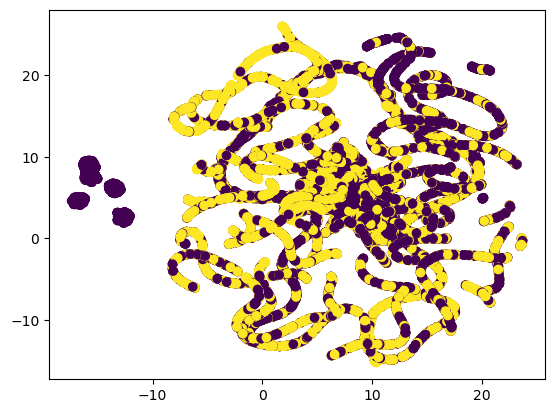

In [27]:
if __name__ == '__main__':
	umap_model(valx, valy, 0)
	umap_model(valx, valy, 5)
	umap_model(valx, valy, 7)
	umap_model(valx, valy, 9)
	umap_model(valx, valy, 10)
	umap_model(valx, valy, 11)